In [1]:
# plotly standard imports
import plotly.graph_objs as go
import chart_studio.plotly as py

# Cufflinks wrapper on plotly
import cufflinks

# Data science imports
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot, init_notebook_mode
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Window Generator

For split input dataset on qual batches need split them on windows.
Will use WindowGenerator class for spliting data into batches

## Explore datasets

In [2]:
from src.prepare_datasets import get_prepared_datasets

train_df, test_df = get_prepared_datasets()

train_df.head()

train_df.iplot(subplots=True)

,High,Low,Open,Close,Volume,H-L,H-PC,L-PC,MACD,Stochastics Oscillator,ATR
0,-0.299748,-0.297151,-0.299743,-0.299323,-0.160839,-0.087686,-0.047916,-0.047425,-0.001011,0.228092,-0.087851
1,-0.299392,-0.296098,-0.299312,-0.298805,-0.160130,-0.090669,-0.048271,-0.050183,0.000026,0.288811,-0.090834
2,-0.299059,-0.300930,-0.298709,-0.302135,-0.155526,-0.067820,-0.049169,-0.025769,-0.000997,-0.101661,-0.067985
3,-0.303130,-0.303856,-0.302548,-0.306853,-0.154607,-0.073906,-0.049369,-0.028018,-0.004112,-0.550830,-0.072204
4,-0.306588,-0.311709,-0.306889,-0.313664,-0.155760,-0.055412,-0.047653,-0.014331,-0.009678,-0.550830,-0.055576


## Calculate batch size

In [3]:
from src.window_generator import WindowGenerator

w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, 
    train_df=train_df, test_df=test_df, 
    label_columns=['Close']
)

w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Close']

n 0 from 3
n 1 from 3
n 2 from 3


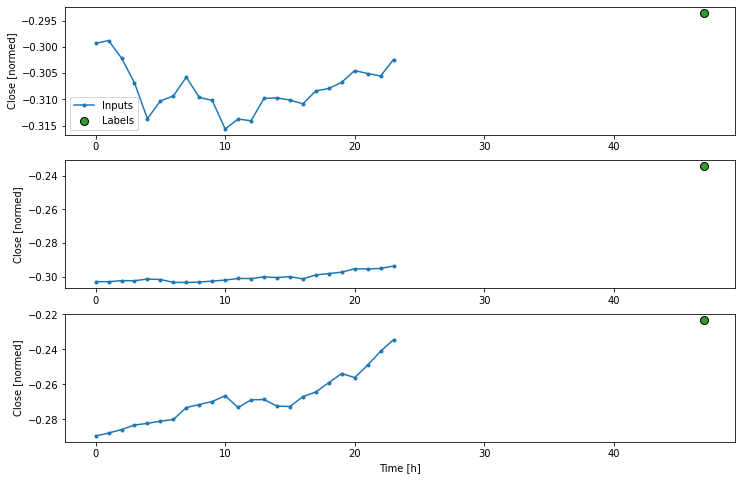

In [4]:
w1.plot(plot_col='Close')

In [5]:
w1.train.element_spec

(TensorSpec(shape=(None, 24, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Try baseline model

In [6]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, test_df=test_df, 
    label_columns=['Close'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [7]:
import tensorflow as tf
from src.BaselineModel import Baseline

column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline = Baseline(label_index=column_indices['Close'])
    
baseline.compile(
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredLogarithmicError()]
)

In [8]:
baseline.evaluate(single_step_window.test, verbose=1)

139/139 [==============================] - 0s 1ms/step - loss: 5.8667e-04 - mean_absolute_error: 0.0127 - mean_squared_logarithmic_error: 2.0362e-04


[0.0032301454339176416, 0.02965100295841694, 0.0005371642182581127]

In [9]:
wide_window = WindowGenerator(
    input_width=32, label_width=32, shift=1,
    train_df=train_df, test_df=test_df,
    label_columns=['Close'])

wide_window

Total window size: 33
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Label column name(s): ['Close']

In [10]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (33, 32, 11)
Output shape: (33, 32, 1)


n 0 from 3
len(inputs) 33
n 1 from 3
len(inputs) 33
n 2 from 3
len(inputs) 33


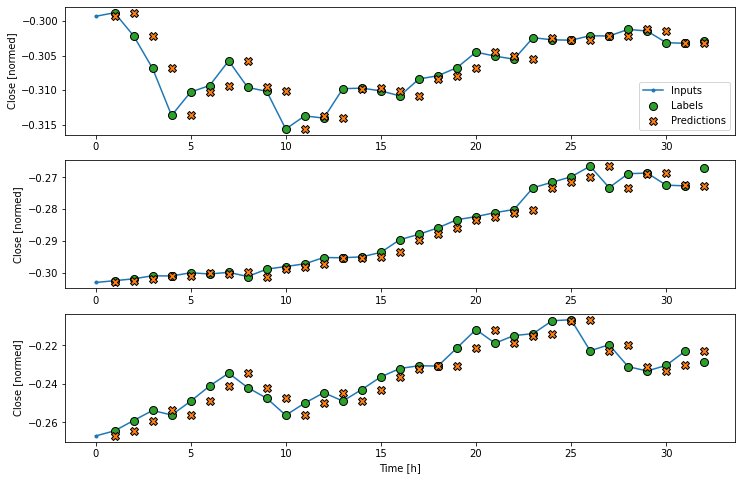

In [11]:
wide_window.plot(baseline)